# Data sets Carian and Jan

   Zeit  Butanal-200  Butyroin-200  Octandiol-200  Butanal-400  Butyroin-400  \
0     0    96.594128      0.146979       0.087363   132.846287      0.146979   
1    15    59.927461     44.956117       0.087363    37.146805     42.250977   
2    30    32.483592     52.241960       1.252210    22.656304     46.116321   
3    60    14.210708     50.035768       2.770671    11.930915     44.421100   
4   120    11.326425     68.722272       6.494020     4.953368     42.317102   

   Octandiol-400  
0       0.087363  
1       2.937077  
2       3.623505  
3      10.799792  
4      16.083203  
0       0
1      15
2      30
3      60
4     120
5     260
6     360
7    1440
Name: Zeit, dtype: int64


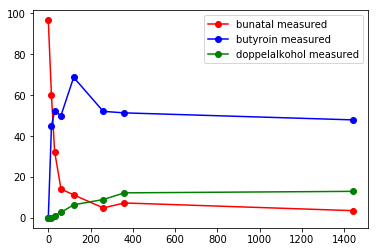

In [3]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

print(df.head())

butanal = df["Butanal-200"]
butyroin = df["Butyroin-200"]
octandiol = df["Octandiol-200"]

time = df["Zeit"]

print(time)

fix, ax = plt.subplots()

ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="-", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="-", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="-", marker="o")
ax.legend()
plt.plot()
plt.show()
